In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import shortest_path as sp
import random

dir = "/Users/ozgun/Data/Josh/"
#dir = "/home/ozgunbabur/Data/Josh/"

data_file = dir + "normalized_mat.tsv"

pca_pre_file = dir + "pca_coords_8.tsv"
pca_file = dir + "pca_8.tsv"

umap_coords = dir + "umap_coords.tsv"
umap_file = dir + "umap_coords_transposed.tsv"
dist_euc_file = dir + "dist_euclidean.tsv"
dist_cos_file = dir + "dist_cosine.tsv"
dist_cos_asis_file = dir + "dist_cosine_asis.tsv"
dist_um_file = dir + "dist_umap.tsv"



In [10]:
def get_similarity_matrix_df(dataF):
    return get_similarity_matrix(dataF.to_numpy())

def get_similarity_matrix(m):
    nRow, nCol = m.shape
    sim_mat = np.full((nCol, nCol), 0.0)

    for i in range(0, nCol):
        for j in range(i, nCol):
            dif = m[:, i] - m[:, j]
            d = np.dot(dif, dif)
            s = np.exp(-d * 1)
            sim_mat[i][j] = s
            sim_mat[j][i] = s

    return sim_mat

def get_probability_matrix(sim_mat):
    sums = np.sum(sim_mat, axis=1)
    p_mat = (sim_mat.T / sums).T
    return p_mat

def get_flow_matrix(p_matrix, heat):
    return (heat * p_matrix.T).T

def get_next_heat(flow):
    return np.sum(flow, axis=0)

def generate_flow_matrices(p_matrix, source_indicator, target_indicator, k:int):
    flow_list = []
    sink_list = []

    heat = np.zeros(len(source_indicator))
    heat[source_indicator] = 1

    deriv = 1

    while (k < 0 < deriv) or (k > len(flow_list)):
        flow = get_flow_matrix(p_matrix, heat)
        flow_list.append(flow)
        heat = get_next_heat(flow)
        sink_list.append(np.sum(heat[target_indicator]))

        if len(sink_list) > 1:
            deriv = sink_list[-1] - sink_list[-2]

    return flow_list, sink_list

def normalize_weights(weights):
    sum = np.sum(weights)
    return weights / sum

def generate_weights(flow_matrices, target_indicator, arrive_index:int):
    if arrive_index == -1:
        arrive_index = len(flow_matrices) - 1

    cell_size = len(target_indicator)
    weights_mat = np.zeros((arrive_index + 2, cell_size))

    weights = np.zeros(cell_size)
    weights[target_indicator] = 1
    weights = normalize_weights(weights)

    weights_mat[arrive_index+1,:] = weights
    index = arrive_index

    while index >= 0:
        weights = np.matmul(flow_matrices[index], weights.T)
        weights = normalize_weights(weights)
        weights_mat[index, :] = weights
        index = index - 1

    return weights_mat

def get_sink_vector(flow_matrices, target_indicator):
    sinks = []
    for i in range(len(flow_matrices)):
        flow = flow_matrices[i]
        sink = np.sum(flow[:, target_indicator])
        sinks.append(sink)
    return sinks

def get_color_string(val):
    hex_col = mc.to_hex([1-val, 1-val, 1-val])
    return hex_col


In [11]:
dataF = pd.read_table(umap_file, index_col=0)
#dataF = pd.read_table(pca_file, index_col=0)
cols = dataF.columns.values.tolist()
size = len(cols)

src_ind = cols.index('tumor_GGGCATCAGTGTACCT-1') #45
#src_ind = cols.index('midpoint_AACACGTTCGGCGCTA-1') #892
trg_ind = cols.index('midpoint_TGGTTCCTCACTATTC-1') #1

source_indicator = np.full(size, False)
source_indicator[src_ind] = True
target_indicator = np.full(size, False)
target_indicator[trg_ind] = True

sim = get_similarity_matrix_df(dataF)
p_mat = get_probability_matrix(sim)
p_mat[target_indicator,:] = 0

print("Probabilities set")

heat = np.zeros(size)
heat[source_indicator] = 1

Probabilities set


In [ ]:

flows, sinks = generate_flow_matrices(p_mat, source_indicator, target_indicator, -1)

print("flows length = " + str(len(flows)))

#plt.figure(figsize=(15, 15))
#ax = plt.axes()
#ax.scatter(np.array(range(len(sinks))), sinks, color = 'k', alpha=1)
#plt.show()

weights = generate_weights(flows, target_indicator, -1)
print("weights = \n" + str(weights))
cum_w = np.sum(weights, axis=0)
print("cum_w = \n" + str(cum_w))


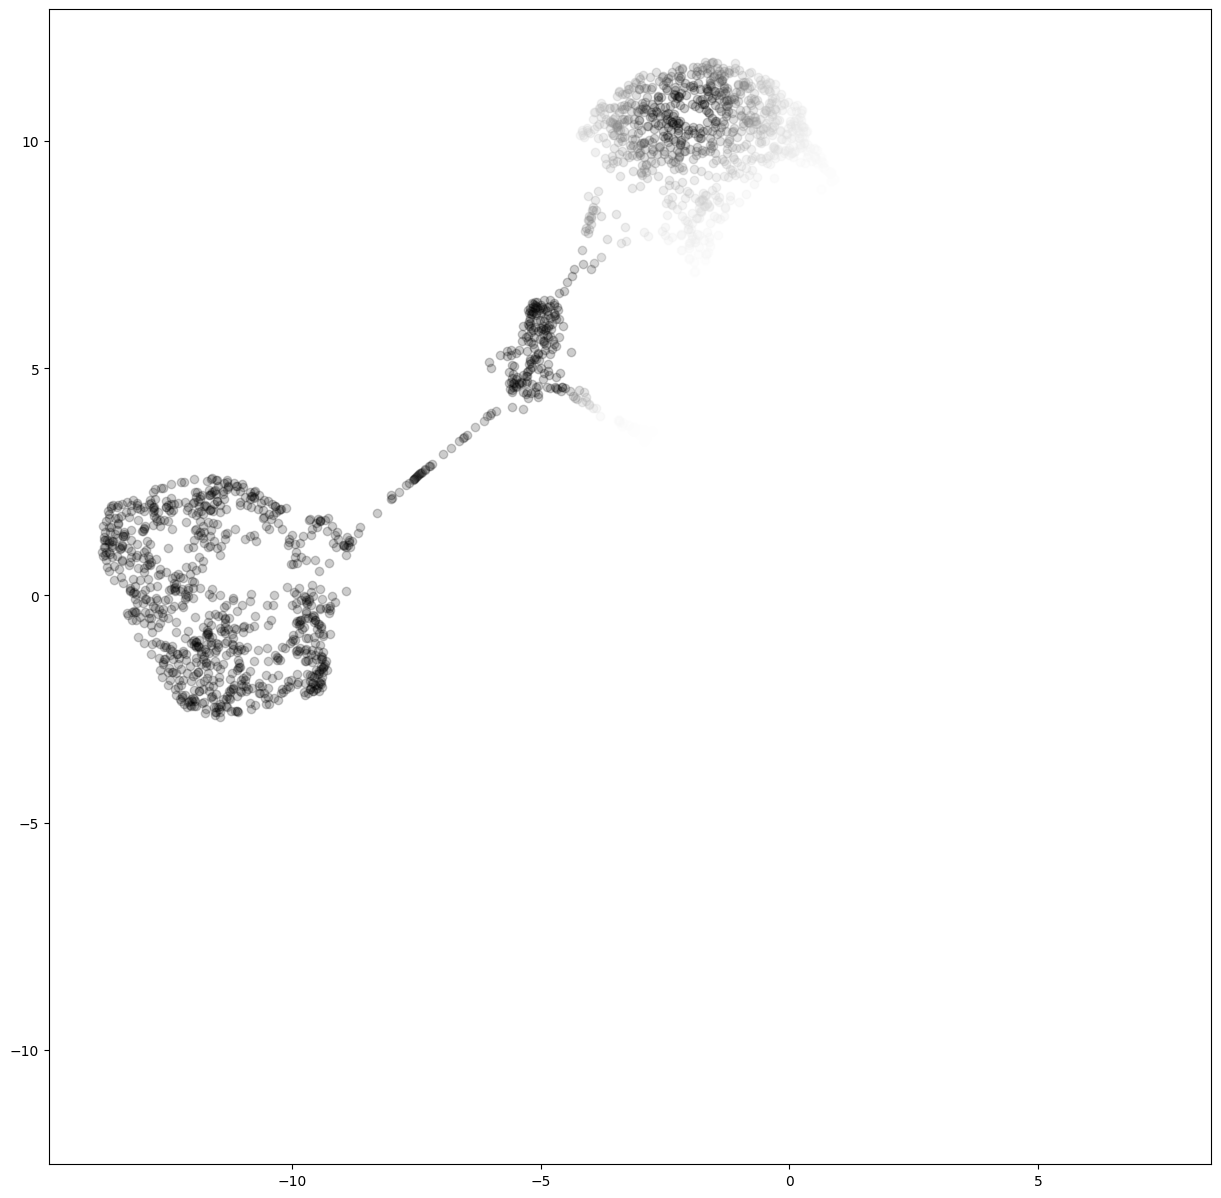

In [13]:
table = pd.read_table(umap_file, index_col=0)
mat = table.to_numpy()
plt.figure(figsize=(15, 15))
ax = plt.axes()
for i in range(len(mat[0])):
    val = cum_w[i]
    val = min (val * 100, 1)
    ax.scatter([mat[0][i]], [mat[1][i]], color = get_color_string(val), alpha=0.2)


In [9]:
print(np.mean(sim))

0.3881331098085228


In [6]:
size = 10
data = np.array([range(size), range(size)])
sim = get_similarity_matrix(data)

source_indicator = np.full(size, False)
source_indicator[4] = True
target_indicator = np.full(size, False)
target_indicator[size-1] = True

h = np.zeros(size)
h[source_indicator] = 1

print(sim)
print('h=\n' + str(h))

p = get_probability_matrix(sim)
p[target_indicator,:] = 0
print('p=\n' + str(p))

flows = generate_flow_matrices(p, source_indicator, target_indicator)

print("flows length = " + str(len(flows)))

weights = generate_weights(flows, target_indicator, -1)
print("weights = \n" + str(weights))
cum_w = np.sum(weights, axis=0)

print("cum_w = \n" + str(cum_w))

[[1.         0.98019867 0.92311635 0.83527021 0.72614904 0.60653066
  0.48675226 0.3753111  0.2780373  0.1978987 ]
 [0.98019867 1.         0.98019867 0.92311635 0.83527021 0.72614904
  0.60653066 0.48675226 0.3753111  0.2780373 ]
 [0.92311635 0.98019867 1.         0.98019867 0.92311635 0.83527021
  0.72614904 0.60653066 0.48675226 0.3753111 ]
 [0.83527021 0.92311635 0.98019867 1.         0.98019867 0.92311635
  0.83527021 0.72614904 0.60653066 0.48675226]
 [0.72614904 0.83527021 0.92311635 0.98019867 1.         0.98019867
  0.92311635 0.83527021 0.72614904 0.60653066]
 [0.60653066 0.72614904 0.83527021 0.92311635 0.98019867 1.
  0.98019867 0.92311635 0.83527021 0.72614904]
 [0.48675226 0.60653066 0.72614904 0.83527021 0.92311635 0.98019867
  1.         0.98019867 0.92311635 0.83527021]
 [0.3753111  0.48675226 0.60653066 0.72614904 0.83527021 0.92311635
  0.98019867 1.         0.98019867 0.92311635]
 [0.2780373  0.3753111  0.48675226 0.60653066 0.72614904 0.83527021
  0.92311635 0.98019

TypeError: generate_flow_matrices() missing 1 required positional argument: 'k'